# FIM590: Machine Learning Project 1
## Iowa Housing Prices Modeling
George Armentrout
Isaac Gohn
Qiao Feng
Divija Balasankula


In this project, information regarding approximately 2000 real estate listings in Iowa will be utilized in modeling the sale price of houses in the region.

Several different models will be employed. Although they are all linear regressions, each approach will have slight variation in their regularization method. Specifically, all regressions will utilize the mean square error loss function, however one model will have no regularization, one model wil use Ridge Regression with $\lambda = 0.10,0.30,0.60,$, and one model will use Lasso Regression with $\lambda = 0.02,0.06,0.10$.

This process is comprised of several components, listed as followed:
1. Investigate the provided data and features and decide which features to use in the regression.
2. Clean the data to contain only the features to be utilized and the associated sale price.
3. Divide the given dataset into the necessary subsets (training, validation, and test sets).
4. Utilizing the package Scikit-Learn, implement the specified models.
5. Train the models using the training set.
6. Utilize the validation set to select the best model.
7. Evaluate the model's performance with the test data set.

### 1. Determining Features for Regression

In the dataset provided, there are 79 features listed with each real estate listing in addition to the sale price of the listing itself. Generally, including more features can allow for a more precise and accurate model. However, allowing for too may features may not be in the best interest of the model. This can be due to overfitting, where a model follows a dataset too closely and only accurately models the training dataset rather than the phenomena itself. Additionally, increasing the number of features demands more computational power, lowering the efficiency of the regression and worsening the performance of the model itself. For this project, 47 features are being considered as followed:

- Lot area (square feet)
- Overall quality (scale: 1 to 10)
- Overall condition (scale: 1 to 10)
- Year built
- Year remodeled (= year built if no remodeling or additions)
- Finished basement (square feet)
- Unfinished basement (square feet)
- Total basement (square feet)
- First floor (square feet)
- Second floor (square feet)
- Living area (square feet)
- Number of full bathrooms
- Number of half bathrooms
- Number of bedrooms
- Total rooms above grade
- Number of fireplaces
- Parking spaces in garage
- Garage area (square feet)
- Wood deck (square feet)
- Open porch (square feet)
- Enclosed porch (square feet)
- Neighborhood (25 features)*
- Basement quality**

\* There are 25 unique neighborhoods in the dataset. Each neighborhood is implemented as a binary feature (1 if the listing is in the specified neighborhood, 0 if not).

\*\* Basement quality is a qualitative metric that is categorized as either 'Excellent,' 'Good,' 'Typical,' 'Fair,' 'Poor,' or 'No basement.' For this regression, this metric is assigned a value of 5, 4, 3, 2, 1, or 0, respectively.

### 2. Cleaning the Data

With the above determination of features to be utilized in the regression, there is a large amount of superfluous data present in the dataset. Additionally, several of these datapoints need to be derived from information provided in the dataset. In cleaning this dataset, first ensure that all features needed for the regression are calculated and present. These can be in either pre-existing columns or new columns of the dataframe.

- Lot area (square feet): "LotArea"
- Overall quality (scale: 1 to 10): "OverallQual"
- Overall condition (scale: 1 to 10): "OverallCond"
- Year built: "YearBuilt"
- Year remodeled (= year built if no remodeling or additions): "YearRemodAdd"
- Finished basement (square feet): **Added "BsmtFinSF"**
- Unfinished basement (square feet): "BsmtUnfSF"
- Total basement (square feet): "TotalBsmtSF"
- First floor (square feet): "1stFlrSF"
- Second floor (square feet): "2ndFlrSF"
- Living area (square feet): "GrLivArea"
- Number of full bathrooms: "FullBath"
- Number of half bathrooms: "HalfBath"
- Number of bedrooms: "BedroomAbvGr"
- Total rooms above grade: "TotRmsAbvGrd"
- Number of fireplaces: "Fireplaces"
- Parking spaces in garage: "GarageCars"
- Garage area (square feet): "GarageArea"
- Wood deck (square feet): "WoodDeckSF"
- Open porch (square feet): "OpenPorchSF"
- Enclosed porch (square feet): "EnclosedPorch"
- Neighborhood (25 features): **Added "neighborhoodName"**
- Basement quality: **Added "BsmtQualNum"**

Please note, typically any bedrooms or bathrooms built below grade (in the basement) are not included in the count of bedrooms and bathrooms in appraisal, and therefore are not included in the number of full/half bathrooms or bedrooms. Similarly, no finished basement square footage is included in the living area feature.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [115]:
#Read the Data
housing_data = pd.read_excel("IA_House_Price_Original_Data.xlsx",header=3,index_col=0)
housing_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Unnamed: 81,Unnamed: 82
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,0,2,2008,WD,Normal,208500,NaN,NaN
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,0,5,2007,WD,Normal,181500,NaN,NaN
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,0,9,2008,WD,Normal,223500,NaN,NaN
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,0,2,2006,WD,Abnorml,140000,NaN,NaN
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,0,12,2008,WD,Normal,250000,NaN,NaN


In [116]:
#Data Cleaning: Basement Numbers
#Add Feature "BsmtFinSF" to count the square footage of the Finished Basement
housing_data["BsmtFinSF"] = housing_data["BsmtFinSF1"] + housing_data["BsmtFinSF2"]

#Add Feature "BsmtQualNum" to quantify the basement quality
basement_conditions = [
    (housing_data["BsmtQual"] == "Ex"),
    (housing_data["BsmtQual"] == "Gd"),
    (housing_data["BsmtQual"] == "Ta"),
    (housing_data["BsmtQual"] == "Fa"),
    (housing_data["BsmtQual"] == "Po"),
    (housing_data["BsmtQual"] == "NA"),
]

basement_quality_numbers = [5,4,3,2,1,0]

housing_data["BsmtQualNum"] = np.select(basement_conditions,basement_quality_numbers)

In [117]:
#Converting the categorical 'Neighbourhood' column to integer codes
housing_data_copy = housing_data.copy() #Created a copy of the DataFrame so there is no potential loss of data

housing_data_copy['Neighborhood'] = pd.factorize(housing_data['Neighborhood'])[0]

housing_data_copy['Neighborhood'].head()

Id
1    0
2    1
3    0
4    2
5    3
Name: Neighborhood, dtype: int64

In [118]:
housing_data_copy.head()

housing_data_copy.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

Next, remove the unneeded data from the dataset. This helps promote organized and intentional data and can make analyzing the features in the regression easier.

In [119]:
#Keep only required columns
housing_data_v1clean = housing_data_copy.drop(['MSSubClass', 'MSZoning', 'LotFrontage', 'Street', 
                                                'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
                                                'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 
                                                'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
                                                'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual','BsmtCond', 
                                                'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1','BsmtFinSF2','BsmtFinType2', 'Heating', 
                                                'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 
                                                'BsmtFullBath', 'BsmtHalfBath', 'KitchenAbvGr', 'KitchenQual', 
                                                'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 
                                                'GarageQual', 'GarageCond', 'PavedDrive', '3SsnPorch', 'ScreenPorch', 
                                                'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 
                                                'YrSold', 'SaleType', 'SaleCondition', 'Unnamed: 81', 'Unnamed: 82'], axis=1)


housing_data_v1clean.describe()


,LotArea,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,SalePrice,BsmtFinSF,BsmtQualNum
count,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,...,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000
mean,10120.229711,9.564649,6.083906,5.566713,1971.296080,1984.254470,560.858322,1047.269601,1154.885144,335.069120,...,6.444635,0.594911,1.764787,471.883081,93.349381,47.099037,23.054677,180272.213549,486.411279,2.154058
std,7794.469991,5.752218,1.396532,1.111292,30.272561,20.884877,439.823652,419.916367,375.324590,426.268871,...,1.554434,0.643243,0.760912,214.162896,126.262027,66.642347,64.200383,78139.090808,459.877980,2.071228
min,1300.000000,0.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,334.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12789.000000,0.000000,0.000000
25%,7466.500000,5.000000,5.000000,5.000000,1954.000000,1965.000000,220.000000,793.000000,876.000000,0.000000,...,5.000000,0.000000,1.000000,320.000000,0.000000,0.000000,0.000000,129362.500000,0.000000,0.000000
50%,9444.500000,10.000000,6.000000,5.000000,1973.000000,1993.000000,467.500000,988.500000,1082.000000,0.000000,...,6.000000,1.000000,2.000000,479.000000,0.000000,26.000000,0.000000,160000.000000,456.000000,4.000000
75%,11521.500000,13.000000,7.000000,6.000000,2001.000000,2004.000000,804.500000,1300.000000,1383.000000,704.000000,...,7.000000,1.000000,2.000000,576.000000,168.000000,70.000000,0.000000,213310.000000,803.250000,4.000000
max,215245.000000,24.000000,10.000000,9.000000,2010.000000,2010.000000,2336.000000,3206.000000,3820.000000,1862.000000,...,14.000000,4.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,625000.000000,2461.000000,5.000000


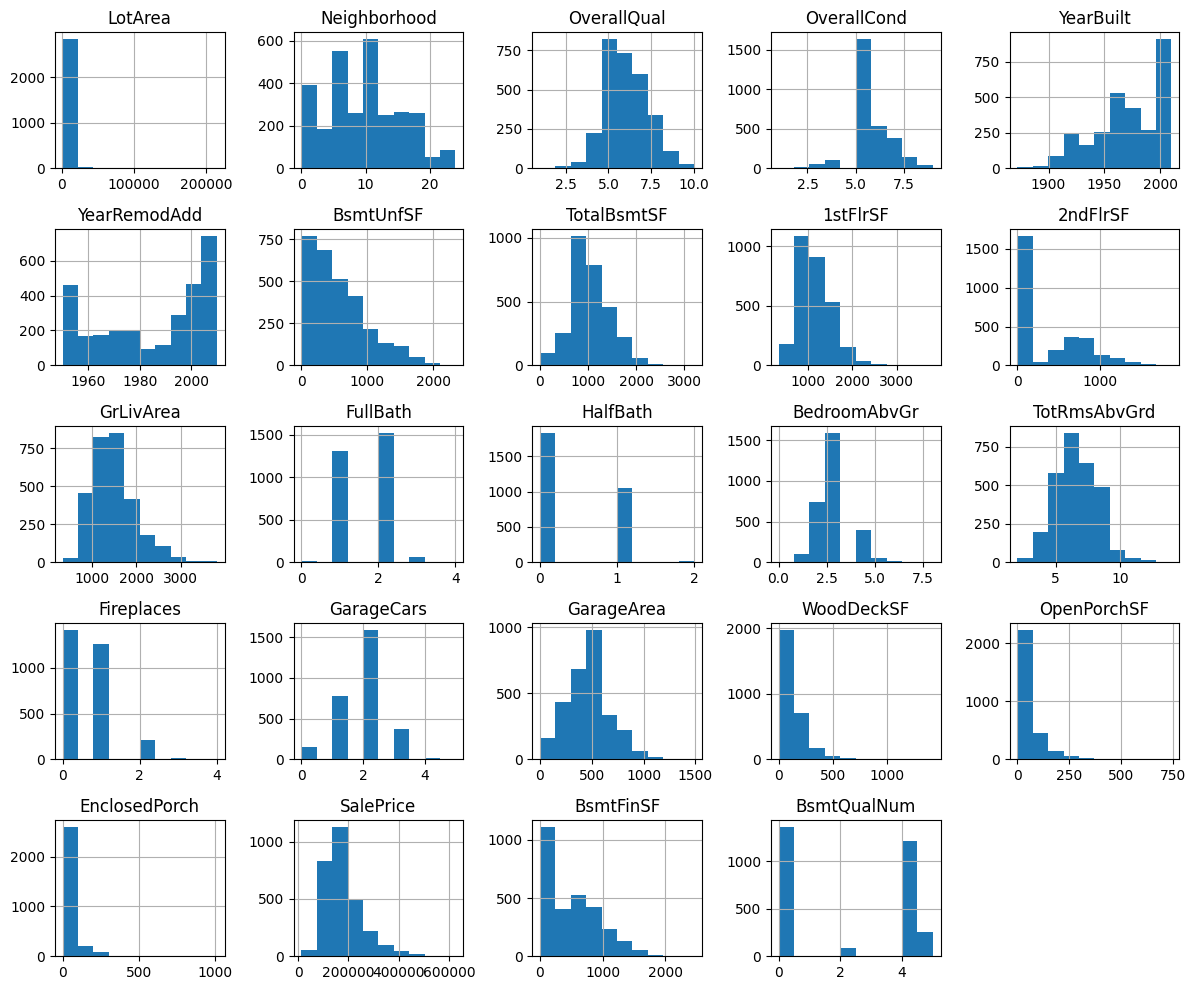

In [120]:
#Visual Analysis: Plot the modified data

housing_data_v1clean.hist(bins=10, figsize=(12,10))
plt.tight_layout()
plt.show()

In [121]:
#Data Cleaning: Convert Neighbourhood data to indicator variables (creates binary (0 or 1) colums for each category)
 
housing_data_finalversion = pd.get_dummies(housing_data_v1clean, columns=['Neighborhood'], dtype=int)
housing_data_finalversion.head()

# for feature in housing_data_dummies:
#     # print(feature)
#     mean_value=housing_data_dummies[feature].mean()
#     #print(mean_value)
#     housing_data_dummies[feature].fillna(mean_value, inplace=True)


,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,...,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24
Id,,,,,,,,,,,,,,,,,,,,,
1,8450,7,5,2003,2003,150,856,856,854,1710,...,0,0,0,0,0,0,0,0,0,0
2,9600,6,8,1976,1976,284,1262,1262,0,1262,...,0,0,0,0,0,0,0,0,0,0
3,11250,7,5,2001,2002,434,920,920,866,1786,...,0,0,0,0,0,0,0,0,0,0
4,9550,7,5,1915,1970,540,756,961,756,1717,...,0,0,0,0,0,0,0,0,0,0
5,14260,8,5,2000,2000,490,1145,1145,1053,2198,...,0,0,0,0,0,0,0,0,0,0


In [130]:
housing_data_finalversion.describe()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,...,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24
count,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,...,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000
mean,10120.229711,6.083906,5.566713,1971.296080,1984.254470,560.858322,1047.269601,1154.885144,335.069120,1494.627235,...,0.065681,0.024759,0.056740,0.017538,0.015131,0.007909,0.009629,0.010316,0.016506,0.003439
std,7794.469991,1.396532,1.111292,30.272561,20.884877,439.823652,419.916367,375.324590,426.268871,486.035830,...,0.247766,0.155417,0.231385,0.131287,0.122094,0.088597,0.097669,0.101062,0.127434,0.058550
min,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,334.000000,0.000000,334.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7466.500000,5.000000,5.000000,1954.000000,1965.000000,220.000000,793.000000,876.000000,0.000000,1125.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9444.500000,6.000000,5.000000,1973.000000,1993.000000,467.500000,988.500000,1082.000000,0.000000,1442.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,11521.500000,7.000000,6.000000,2001.000000,2004.000000,804.500000,1300.000000,1383.000000,704.000000,1740.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,215245.000000,10.000000,9.000000,2010.000000,2010.000000,2336.000000,3206.000000,3820.000000,1862.000000,3820.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [131]:
housing_data_finalversion.columns

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'SalePrice', 'BsmtFinSF', 'BsmtQualNum',
       'Neighborhood_0', 'Neighborhood_1', 'Neighborhood_2', 'Neighborhood_3',
       'Neighborhood_4', 'Neighborhood_5', 'Neighborhood_6', 'Neighborhood_7',
       'Neighborhood_8', 'Neighborhood_9', 'Neighborhood_10',
       'Neighborhood_11', 'Neighborhood_12', 'Neighborhood_13',
       'Neighborhood_14', 'Neighborhood_15', 'Neighborhood_16',
       'Neighborhood_17', 'Neighborhood_18', 'Neighborhood_19',
       'Neighborhood_20', 'Neighborhood_21', 'Neighborhood_22',
       'Neighborhood_23', 'Neighborhood_24'],
      dtype='object')

In [134]:
housing_data_finalversion.shape

(2908, 48)

In [136]:
#Normalize the data
# columns_to_normalize = ['LotArea', 'BsmtFinSF', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice']
columns_to_normalize = housing_data_finalversion.columns
data_to_normalize = housing_data_finalversion[columns_to_normalize]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#Fit the scaler to data and transform it
# normalized_data = scaler.fit_transform(data_to_normalize) 
normalized_data = scaler.fit_transform(data_to_normalize)

#Create new DataFrame with the normalized data 
normalized_housing_data = pd.DataFrame(normalized_data, columns=columns_to_normalize)

#Keep other non-normalized columns. Combine the DataFrames
result_housing_data = pd.concat([housing_data_finalversion.drop(columns=columns_to_normalize), normalized_housing_data], axis=1)

#Save only normalized columns
normalized_housing_data.to_csv('normalized housing data', index=True)

#Save full dataset with normalized columns
result_housing_data.to_csv('full housing data w normalized col.csv', index=True)


In [137]:
normalized_housing_data.describe()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,...,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24
count,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,...,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000
mean,0.041227,0.564878,0.570839,0.719537,0.570908,0.240093,0.326659,0.235481,0.179951,0.332940,...,0.065681,0.024759,0.056740,0.017538,0.015131,0.007909,0.009629,0.010316,0.016506,0.003439
std,0.036432,0.155170,0.138912,0.219366,0.348081,0.188281,0.130978,0.107666,0.228931,0.139425,...,0.247766,0.155417,0.231385,0.131287,0.122094,0.088597,0.097669,0.101062,0.127434,0.058550
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.028823,0.444444,0.500000,0.594203,0.250000,0.094178,0.247349,0.155479,0.000000,0.227123,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.038068,0.555556,0.500000,0.731884,0.716667,0.200128,0.308328,0.214573,0.000000,0.317843,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.047776,0.666667,0.625000,0.934783,0.900000,0.344392,0.405490,0.300918,0.378088,0.403471,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [138]:
result_housing_data.describe()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,...,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24
count,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,...,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000
mean,0.041227,0.564878,0.570839,0.719537,0.570908,0.240093,0.326659,0.235481,0.179951,0.332940,...,0.065681,0.024759,0.056740,0.017538,0.015131,0.007909,0.009629,0.010316,0.016506,0.003439
std,0.036432,0.155170,0.138912,0.219366,0.348081,0.188281,0.130978,0.107666,0.228931,0.139425,...,0.247766,0.155417,0.231385,0.131287,0.122094,0.088597,0.097669,0.101062,0.127434,0.058550
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.028823,0.444444,0.500000,0.594203,0.250000,0.094178,0.247349,0.155479,0.000000,0.227123,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.038068,0.555556,0.500000,0.731884,0.716667,0.200128,0.308328,0.214573,0.000000,0.317843,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.047776,0.666667,0.625000,0.934783,0.900000,0.344392,0.405490,0.300918,0.378088,0.403471,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [172]:
#Identify rows with NaN values across all columns
rows_with_all_nan = result_housing_data[result_housing_data.isna().all(axis=1)]
print(f'Rows with all NaN values:{rows_with_all_nan}')

#Get indices of these rows
rows_with_all_nan_index = rows_with_all_nan.index.tolist()
print(f'\nIndex of rows with all NaN values: {rows_with_all_nan_index}')

#Drop the rows
cleaned_result_housing_data = result_housing_data.dropna(how='all')


Rows with all NaN values:      LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  BsmtUnfSF  \
2908      NaN          NaN          NaN        NaN           NaN        NaN   
2909      NaN          NaN          NaN        NaN           NaN        NaN   
2910      NaN          NaN          NaN        NaN           NaN        NaN   
2911      NaN          NaN          NaN        NaN           NaN        NaN   
2912      NaN          NaN          NaN        NaN           NaN        NaN   
2913      NaN          NaN          NaN        NaN           NaN        NaN   
2914      NaN          NaN          NaN        NaN           NaN        NaN   
2915      NaN          NaN          NaN        NaN           NaN        NaN   
2916      NaN          NaN          NaN        NaN           NaN        NaN   
2917      NaN          NaN          NaN        NaN           NaN        NaN   
2918      NaN          NaN          NaN        NaN           NaN        NaN   
2919      NaN          NaN 

### 3. Partition the Training, Validation, and Test Sets

First, divide the cleaned data set into the features and the sale price. Then, utilizing Sklearn's train_test_split() function to randomly generate the appropriate training, validation, and test sets. Note that this function only splits the dataset into two groups, so the function is used twice (split into two groups, then split the second group into the second and third group).

In [173]:
#Prepare features and target variable
X = cleaned_result_housing_data.drop(['SalePrice'], axis=1)
y = cleaned_result_housing_data['SalePrice']

In [174]:
from sklearn.model_selection import train_test_split

In [186]:
#Split data into training, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(X, y, train_size = 1800, random_state=42)
x_validate, x_test, y_validate, y_test = train_test_split(x_temp, y_temp, test_size = len(result_housing_data)-2400, random_state=42)

# Now, (x_train, y_train), (x_valildate, y_validate), (x_test, y_test) represent the three datasets.

#Check sizes of the datasets
train_size = len(x_train)
validate_size = len(x_validate)
test_size = len(x_test)

print(f'Training set size:{train_size}')
print(f'Validation set size:{validate_size}')
print(f'Test set size:{test_size}')


Training set size:1800
Validation set size:588
Test set size:520


In [176]:
x_train.head()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,...,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24
309,0.051780,0.888889,0.500,0.949275,0.900000,0.266267,0.591391,0.461847,0.000000,0.461847,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2254,0.017846,0.777778,0.500,0.855072,0.666667,0.165240,0.409233,0.283133,0.000000,0.283133,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
752,0.030989,0.555556,0.875,0.702899,0.916667,0.049229,0.320025,0.198508,0.000000,0.198508,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1364,0.014653,0.555556,0.500,0.949275,0.900000,0.069777,0.264504,0.147447,0.000000,0.147447,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
911,0.023230,0.444444,0.625,0.557971,0.000000,0.306935,0.312227,0.191337,0.537594,0.478485,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [177]:
x_validate.head()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,...,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24
1081,0.035056,0.555556,0.625,0.666667,0.233333,0.298801,0.390206,0.263052,0.000000,0.263052,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,0.012255,0.666667,0.500,0.971014,0.950000,0.538527,0.392389,0.306368,0.000000,0.306368,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
522,0.017294,0.555556,0.750,0.543478,0.000000,0.258990,0.313163,0.192197,0.354458,0.381526,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1230,0.050761,0.444444,0.500,0.630435,0.150000,0.080479,0.370555,0.244980,0.000000,0.244980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2433,0.014864,0.444444,0.500,0.362319,0.000000,0.102740,0.318777,0.197361,0.000000,0.197361,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [178]:
x_test.head()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,...,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24
2174,0.039496,0.666667,0.500,0.956522,0.900000,0.608305,0.450717,0.318703,0.000000,0.318703,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1410,0.054935,0.555556,0.750,0.369565,0.833333,0.356592,0.259825,0.206254,0.426960,0.434309,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2455,0.022529,0.444444,0.625,0.391304,0.000000,0.173373,0.235808,0.163224,0.203008,0.271658,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1154,0.037626,0.444444,0.875,0.673913,0.816667,0.250856,0.380225,0.267068,0.000000,0.267068,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1039,0.036598,0.555556,0.875,0.681159,0.833333,0.143836,0.249532,0.133678,0.446831,0.372347,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [179]:
y_train.head()

309     0.567143
2254    0.325396
752     0.233924
1364    0.214323
911     0.215957
Name: SalePrice, dtype: float64

In [180]:
y_validate.head()

1081    0.240458
596     0.296323
522     0.238825
1230    0.211056
2433    0.125302
Name: SalePrice, dtype: float64

In [181]:
y_test.head()

2174    0.283744
1410    0.317229
2455    0.195539
1154    0.272963
1039    0.261692
Name: SalePrice, dtype: float64

### 4. Implement the Specified Models

#### Linear Regression
First, consider a traditional linear regression model with no form of regularization. In this model, the cost function is just a standard mean square error function. Specifically, given $n$ features and $m$ points in a dataset, the cost function is:

$$
J(\theta) = \frac{1}{2m}\sum_{i=1}^m(y^{(i)}-h_\theta(x^{(i)}))^2
$$

This model can be implemented utilizing scikit-learn's LinearRegression class.


#### Ridge Regression
The ridge regression model is similar to linear regression, however there is an additional term in the cost function that is based upon the squared magnitude of $\theta$ values. The cost function is specifically:

$$
J(\theta) = \frac{1}{2m}\sum_{i=1}^m(y^{(i)}-h_\theta(x^{(i)}))^2 + \frac{\lambda}{m}\sum_{j=1}^n(\theta_j)^2
$$

Here, there is a parameter $\lambda$ that can be adjusted to establish sensitivity to the additional term. For this project, three different lambda values will be tested ($\lambda = 0.10,0.30,0.60$). This model will also be implemented utilizing scikit-learn's Ridge class.

#### Lasso Regression
The lasso regression model is very similar to ridge regression, except the additional term utilizes absolute value rather than squaring the coefficients.

$$
J(\theta) = \frac{1}{2m}\sum_{i=1}^m(y^{(i)}-h_\theta(x^{(i)}))^2 + \frac{\lambda}{m}\sum_{j=1}^n(\theta_j)^2
$$

Similar to the ridge regression, the parameter $\lambda$ establishes sensitivity to the additional term. For this regression, three different $\lambda$ values will be utilized ($\lambda = 0.02,0.06,0.10$). This model will be implemented utilizing scikit-learn's Lasso class.

### 5. Training the Models
Here, utilizing the specified scikit-learn classes, the models are implemented and trained utilizing the training set. Additionally, the predicted values for the validation set are computed for each regression, as well as the overall mean square error for the validation sets.

In [187]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

In [188]:
#Linear Regression

#Train the Linear regression model
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)

#Predict on validation set
y_pred = linear_model.predict(x_validate)

#Calculate R-squared and MSE
r2_val = r2_score(y_validate, y_pred)
mse_val = mean_squared_error(y_validate, y_pred)

print(f"Validation R-squared: {r2_val:.2f}")
print(f"Validation MSE: {mse_val:.2f}")

Validation R-squared: 0.87
Validation MSE: 0.00


In [204]:
#Ridge Regression

ridge_models = {}
lambda_ridge = [0.10, 0.30, 0.60]

#Train Ridge models for each lambda
for l in lambda_ridge:
    ridge = Ridge(alpha=l)
    ridge.fit(x_train, y_train)
    ridge_models[l] = ridge

#Evaluate Ridge models on validation set
ridge_val_mse = {l: mean_squared_error(y_validate, model.predict(x_validate)) for l, model in ridge_models.items()}

for l in lambda_ridge:
    print(f'\n lambda = {l} : Ridge MSE = {ridge_val_mse[l]}')


 lambda = 0.1 : Ridge MSE = 0.0019504752736217877

 lambda = 0.3 : Ridge MSE = 0.0019525967710407183

 lambda = 0.6 : Ridge MSE = 0.001959458341215258


In [202]:
#Lasso Regression

lasso_models = {}
lambda_lasso = [0.02, 0.06, 0.10]

#Train Lasso models for each lambda
for l in lambda_lasso:
    lasso = Lasso(alpha=1, max_iter=10000)
    lasso.fit(x_train, y_train)
    lasso_models[l] = lasso

#Evaluate Lasso models on validation set
lasso_val_mse = {l: mean_squared_error(y_validate, model.predict(x_validate)) for l, model in lasso_models.items()}

for l in lambda_lasso:
    print(f'\n lambda = {l} : Lasso MSE = {lasso_val_mse[l]}')



 lambda = 0.02 : Lasso MSE = 0.015543666538472998

 lambda = 0.06 : Lasso MSE = 0.015543666538472998

 lambda = 0.1 : Lasso MSE = 0.015543666538472998


### 6. Utilize the Validation Set to Select the Best Model

Now, select the model with the smallest mean squared error of the validation set. Given the large size of the dataset as well as the magnitude of the predicted valeus (100,000's), the mean squared error is naturally quite large. With this in mind, there is not an incredibly large difference between methods with regard to overall mean squared error (the better method being ~1% better than alternatives). As these values were computed above, the best model is therefore the Ridge model with parameter $\lambda=0.60$. 

To get an indication for the accuracy visually, a plot can show the predicted price of the validation set versus the actual sale price. Additionally, the line $y=x$ is graphed as an ideal line this plot should reflect (as the predicted price would ideally be the actual sales price).

In [205]:
#Select the best models based on validation performance
best_lambda_ridge = min(ridge_val_mse, key=ridge_val_mse.get)
best_lambda_lasso = min(lasso_val_mse, key=lasso_val_mse.get)

print(f"Best Ridge lambda {best_lambda_ridge}, MSE: {ridge_val_mse[best_lambda_ridge]}")
print(f"Best Lasso lambda {best_lambda_lasso}, MSE: {lasso_val_mse[best_lambda_lasso]}")

Best Ridge lambda 0.1, MSE: 0.0019504752736217877
Best Lasso lambda 0.02, MSE: 0.015543666538472998


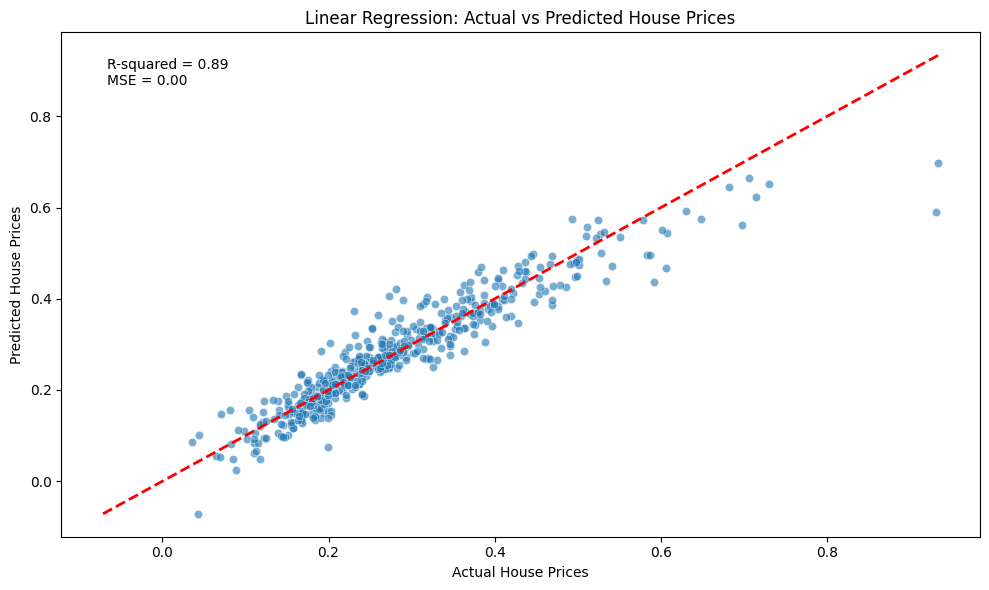

In [207]:
#Get predictions for the test set
y_pred = linear_model.predict(x_test)

#Create the scatter plot
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)

#Add the ideal prediction line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

#Customize the plot
plt.xlabel('Actual House Prices')
plt.ylabel('Predicted House Prices')
plt.title('Linear Regression: Actual vs Predicted House Prices')

#Add text for R-squared and MSE
r2 = linear_model.score(x_test, y_test)
mse = mean_squared_error(y_test, y_pred)
plt.text(0.05, 0.95, f'R-squared = {r2:.2f}\nMSE = {mse:.2f}',
         transform=plt.gca().transAxes, verticalalignment='top')

#Show the plot
plt.tight_layout()
plt.show()

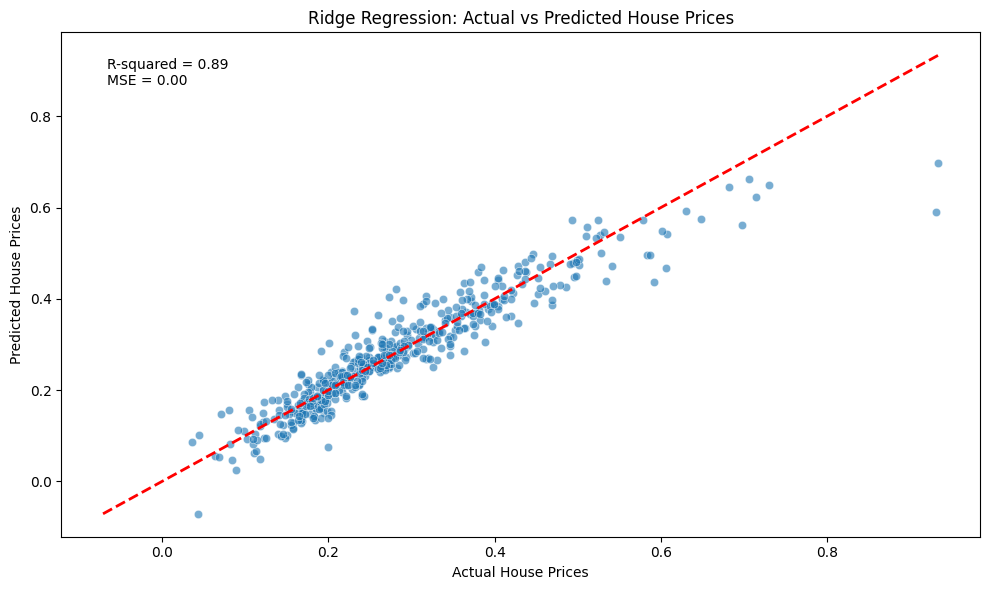

In [210]:
#Choose the best lambda based on validation performance

#Get the best model
ridge_model = ridge_models[best_lambda_ridge]

#Get predictions for the test set
y_pred_ridge = ridge_model.predict(x_test)

#Create the scatter plot
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=y_pred_ridge, alpha=0.6)

#Add the ideal prediction line
min_val = min(y_test.min(), y_pred_ridge.min())
max_val = max(y_test.max(), y_pred_ridge.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

#Customize the plot
plt.xlabel('Actual House Prices')
plt.ylabel('Predicted House Prices')
plt.title('Ridge Regression: Actual vs Predicted House Prices')

#Add text for R-squared and MSE
r2_ridge = ridge_model.score(x_test, y_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
plt.text(0.05, 0.95, f'R-squared = {r2_ridge:.2f}\nMSE = {mse_ridge:.2f}',
         transform=plt.gca().transAxes, verticalalignment='top')

#Show the plot
plt.tight_layout()
plt.show()

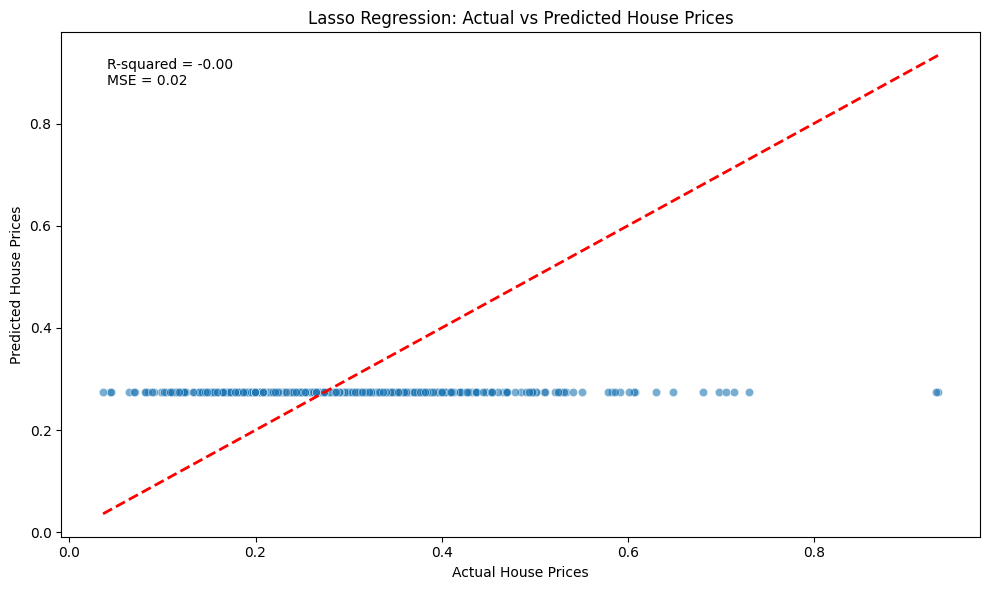

In [211]:
#Choose the best lambda based on validation performance

#Get the best model
lasso_model = lasso_models[best_lambda_lasso]

#Get predictions for the test set
y_pred_lasso = lasso_model.predict(x_test)

#Create a scatter plot for Lasso
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=y_pred_lasso, alpha=0.6)

min_val = min(y_test.min(), y_pred_lasso.min())
max_val = max(y_test.max(), y_pred_lasso.max())

plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
plt.xlabel('Actual House Prices')
plt.ylabel('Predicted House Prices')
plt.title('Lasso Regression: Actual vs Predicted House Prices')

#Add text for R-squared and MSE
r2_lasso = lasso_model.score(x_test, y_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
plt.text(0.05, 0.95, f'R-squared = {r2_lasso:.2f}\nMSE = {mse_lasso:.2f}',
         transform=plt.gca().transAxes, verticalalignment='top')


plt.tight_layout()
plt.show()